# MNIST Digit Classifier

In [1]:
# This cell assumes a project structure of: project-root/src/experiments/this_notebook.ipynb
# We append the parent directory to the system path, so now we can import modules from src
# We also create a variable named path which points to the project root.

import sys
from pathlib import Path

sys.path.append("../") # go to parent dir
path =  str(Path().resolve().parent.parent)

print(path)


/workspaces/Kaggle-Knowledge-Competitions


In [2]:
from dataclasses import dataclass

@dataclass
class Configurations:
    data_dir: str = path + "/data/kaggle_mnist"
    batch_size: int = 64

    lr: float = 0.01
    momentum: float = 0.01

    num_epochs: int = 5

    log_dir: str = path + "/logs/tf-digit-classifier"

cfg = Configurations()

In [3]:
from datasets.kaggle_mnist import get_batched_datasets

train_ds, val_ds, test_ds = get_batched_datasets(cfg.data_dir, cfg.batch_size)
dummy_batch = next(train_ds.as_numpy_iterator())
dummy_batch[0].shape

2022-05-19 15:51:54.856542: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(64, 32, 32, 1)

In [4]:
import keras
import tensorflow as tf
import tensorflow.keras as keras
from models.digit_classifier import ResNet18

model = ResNet18(classes=10, include_top=True, input_shape=(32, 32, 1))
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=cfg.lr, momentum=cfg.momentum),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=cfg.log_dir)

model.fit(train_ds, validation_data=val_ds, epochs=cfg.num_epochs, callbacks=[tensorboard_callback])

/opt/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
525/525 [==============================] - 26s 40ms/step - loss: 0.2915 - categorical_accuracy: 0.9102 - val_loss: 0.1097 - val_categorical_accuracy: 0.9675
Epoch 2/5
525/525 [==============================] - 20s 38ms/step - loss: 0.0731 - categorical_accuracy: 0.9774 - val_loss: 0.0704 - val_categorical_accuracy: 0.9789
Epoch 3/5
525/525 [==============================] - 21s 39ms/step - loss: 0.0237 - categorical_accuracy: 0.9929 - val_loss: 0.0556 - val_categorical_accuracy: 0.9831
Epoch 4/5
525/525 [==============================] - 20s 38ms/step - loss: 0.0048 - categorical_accuracy: 0.9991 - val_loss: 0.0477 - val_categorical_accuracy: 0.9857
Epoch 5/5
525/525 [==============================] - 20s 38ms/step - loss: 9.8798e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0477 - val_categorical_accuracy: 0.9863


In [5]:
import numpy as np
logits = model.predict(test_ds)
preds = np.argmax(logits, axis=-1)

6
5
5
3
1
7
9
1
4
9


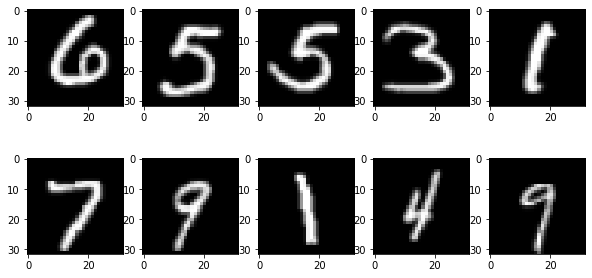

In [6]:
import matplotlib.pyplot as plt
import random
test_ims = list(test_ds.unbatch().as_numpy_iterator())

nrows=2
ncols=5
fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10,5))

for i in range(nrows):
    for j in range(ncols):
        k = random.randint(0,28000)
        axs[i,j].imshow(test_ims[k],cmap="gray")
        print(preds[k])

Finally, save our predictions in the format for Kaggle submission. You can submit by running the following line:
```bash
# submits preds.csv to the mnist classification competition
kaggle competitions submit -c digit-recognizer -f data/kaggle_mnist/preds.csv --message first_submission_with_api
```

In [7]:
import pandas as pd
df = pd.DataFrame({"ImageId" : list(range(1, 28001)),"Label" : preds})
df.to_csv(path+"/data/kaggle_mnist/preds.csv", index=False)